###**1. Data Exploration and Preprocessing**

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import string
import re

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
#Load the dataset
imdb_data = pd.read_excel('/Imdb.xlsx')

In [ ]:
#Basic info of data
imdb_data.info()
imdb_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
#Checking for missing values
missing_values = imdb_data.isnull().sum()
print(missing_values)

review       0
sentiment    0
dtype: int64


In [10]:
#Check for duplicate rows
duplicate_rows = imdb_data[imdb_data.duplicated()]
print(duplicate_rows)

                                                  review sentiment
3537   Quite what the producers of this appalling ada...  negative
3769   My favourite police series of all time turns t...  positive
4391   Beautiful film, pure Cassavetes style. Gena Ro...  positive
6352   If you liked the Grinch movie... go watch that...  negative
6479   I want very much to believe that the above quo...  negative
...                                                  ...       ...
49912  This is an incredible piece of drama and power...  positive
49950  This was a very brief episode that appeared in...  negative
49984  Hello it is I Derrick Cannon and I welcome you...  negative
49986  This movie is a disgrace to the Major League F...  negative
49991  Les Visiteurs, the first movie about the medie...  negative

[419 rows x 2 columns]


In [11]:
#Remove duplicate rows
imdb_data.drop_duplicates(inplace=True)
print(imdb_data.shape)

(49581, 2)


In [ ]:
#Checking for class imbalance
class_counts = imdb_data['sentiment'].value_counts(normalize=True)
print(class_counts)

sentiment
positive    0.501886
negative    0.498114
Name: proportion, dtype: float64


In [ ]:
#Analyze review length
imdb_data['review_length'] = imdb_data['review'].apply(len)
print(imdb_data['review_length'].describe())

count    49581.000000
mean      1310.531312
std        990.788012
min          7.000000
25%        699.000000
50%        971.000000
75%       1592.000000
max      13704.000000
Name: review_length, dtype: float64


In [ ]:
#Identify outliers in review length
Q1 = imdb_data['review_length'].quantile(0.25)
Q3 = imdb_data['review_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = imdb_data[(imdb_data['review_length'] < lower_bound) | (imdb_data['review_length'] > upper_bound)]
print("\nOutliers:")
print(outliers)


Outliers:
                                                  review sentiment  \
26     "The Cell" is an exotic masterpiece, a dizzyin...  positive   
29     War movie' is a Hollywood genre that has been ...  positive   
33     One of the most significant quotes from the en...  positive   
48     Preston Sturgis' THE POWER AND THE GLORY was u...  positive   
51     ***SPOILERS*** All too, in real life as well a...  positive   
...                                                  ...       ...   
49925  What a disaster! Normally, when one critiques ...  negative   
49943  "Sir" has played Lear over 200 times,but tonig...  positive   
49948  It is the early morning of our discontent, and...  negative   
49959  My thoughts on the movie, 9<br /><br />It was ...  negative   
49981  And I repeat, please do not see this movie! Th...  negative   

       review_length  
26              3149  
29              3790  
33              4009  
48              3975  
51              3371  
...       

In [12]:
# Data cleaning and preprocessing
def preprocess_text(data):
  # Convert to lower case
  data = data.lower()
  #Remove HTML tags
  data = re.sub('<.*?','',data)
  #Remove punctuations
  data = data.translate(str.maketrans('','',string.punctuation))
  #Remove special characters
  data = re.sub(r'[^\w\s]', '', data)
  #Tokenize
  tokens = word_tokenize(data)
  #Remove stop words
  stop_words = set(stopwords.words('english'))
  tokens = [words for words in tokens if words not in stop_words]
  #Lemmatizatoin
  lemmetizer = WordNetLemmatizer()
  tokens = [lemmetizer.lemmatize(words) for words in tokens]
  #Stemming
  stemmer = PorterStemmer()
  tokens = [stemmer.stem(words) for words in tokens]
  #Joining the tokens back to string
  data = ' '.join(tokens)
  return data

imdb_data['cleaned_review'] = imdb_data['review'].apply(preprocess_text)

In [ ]:
#Vectorization

#Bag-of-Words
bow_vectorizer = CountVectorizer()
bow_vector = bow_vectorizer.fit_transform(imdb_data['cleaned_review'])



###**2. Feature Engineering**

In [14]:
#Textual features

imdb_data['word_count'] = imdb_data['cleaned_review'].apply(lambda x: len(x.split()))
imdb_data['char_count'] = imdb_data['cleaned_review'].apply(lambda x: len(x))
imdb_data['avg_word_length'] = imdb_data['char_count'] / imdb_data['word_count']

#Split Data
X = imdb_data['cleaned_review']
y = imdb_data['sentiment'].map({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features = 5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


###**3. Model Development**

In [ ]:
#Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
lr_pred = lr.predict(X_test_tfidf)

#Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb_pred = nb.predict(X_test_tfidf)

#Support Vector Machine(SVM)
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
svm_pred = svm.predict(X_test_tfidf)

#Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
rf_pred = rf.predict(X_test_tfidf)

#Neural Network
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=200),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.2)
lstm_preds = lstm_model.predict(X_test_pad).round().astype(int)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 252s 502ms/step - accuracy: 0.7747 - loss: 0.4678 - val_accuracy: 0.8640 - val_loss: 0.3280
Epoch 2/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 245s 495ms/step - accuracy: 0.8915 - loss: 0.2843 - val_accuracy: 0.8659 - val_loss: 0.3302
Epoch 3/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 268s 507ms/step - accuracy: 0.9016 - loss: 0.2533 - val_accuracy: 0.8703 - val_loss: 0.3253
Epoch 4/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 250s 504ms/step - accuracy: 0.9100 - loss: 0.2346 - val_accuracy: 0.8665 - val_loss: 0.3269
Epoch 5/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 265s 510ms/step - accuracy: 0.9221 - loss: 0.2022 - val_accuracy: 0.8737 - val_loss: 0.3433
310/310 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step


###**4. Model Evaluation**

In [ ]:
results = {
    'Logistic Regression': classification_report(y_test, lr_pred, output_dict=True),
    'Naive Bayes': classification_report(y_test, nb_pred, output_dict=True),
    'SVM': classification_report(y_test, svm_pred, output_dict=True),
    'Random Forest': classification_report(y_test, rf_pred, output_dict=True),
    'LSTM': classification_report(y_test, lstm_preds.flatten(), output_dict=True)
}

results

{'Logistic Regression': {'0': {'precision': 0.8981998758535071,
   'recall': 0.8690690690690691,
   'f1-score': 0.8833943833943834,
   'support': 4995.0},
  '1': {'precision': 0.8713611329661684,
   'recall': 0.9000406338886632,
   'f1-score': 0.8854687187687388,
   'support': 4922.0},
  'accuracy': 0.8844408591307855,
  'macro avg': {'precision': 0.8847805044098378,
   'recall': 0.8845548514788661,
   'f1-score': 0.884431551081561,
   'support': 9917.0},
  'weighted avg': {'precision': 0.8848792857061358,
   'recall': 0.8844408591307855,
   'f1-score': 0.8844239163895007,
   'support': 9917.0}},
 'Naive Bayes': {'0': {'precision': 0.8645214183234269,
   'recall': 0.8444444444444444,
   'f1-score': 0.8543649989872392,
   'support': 4995.0},
  '1': {'precision': 0.8457721317983327,
   'recall': 0.8657049979683056,
   'f1-score': 0.8556224899598394,
   'support': 4922.0},
  'accuracy': 0.854996470706867,
  'macro avg': {'precision': 0.8551467750608798,
   'recall': 0.855074721206375,
   

<ipython-input-73-164e5dcc85c4>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette='mako')


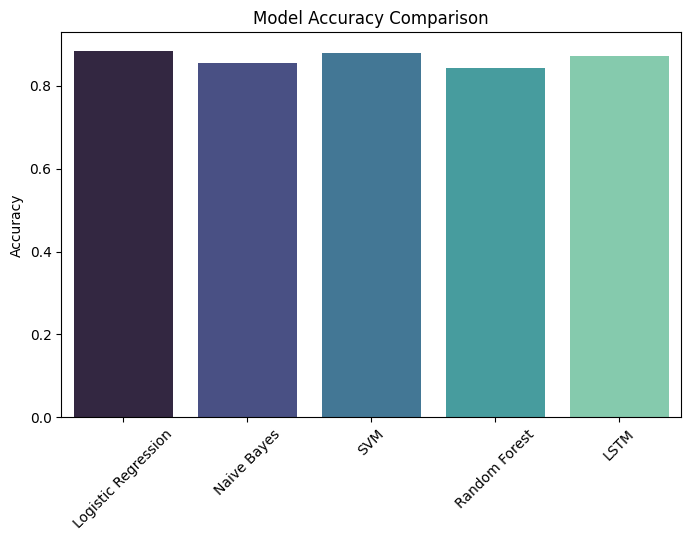

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compile accuracy scores for each model
accuracy_scores = {
    'Logistic Regression': accuracy_score(y_test, lr_pred),
    'Naive Bayes': accuracy_score(y_test, nb_pred),
    'SVM': accuracy_score(y_test, svm_pred),
    'Random Forest': accuracy_score(y_test, rf_pred),
    'LSTM': accuracy_score(y_test, lstm_preds.flatten())
}

# Bar plot of accuracy scores
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette='mako')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

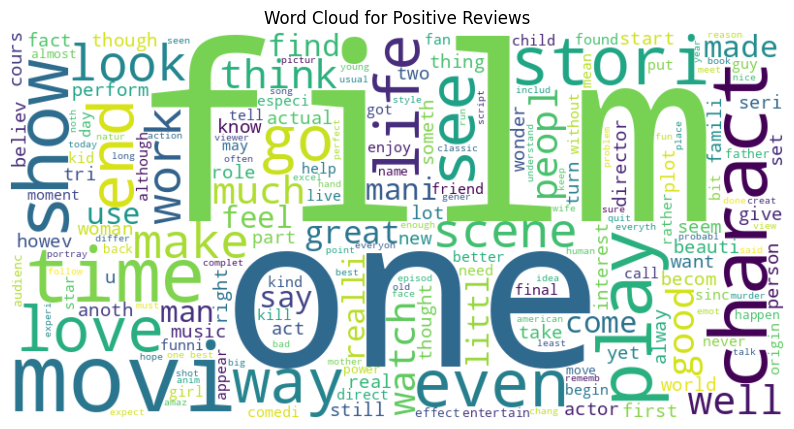

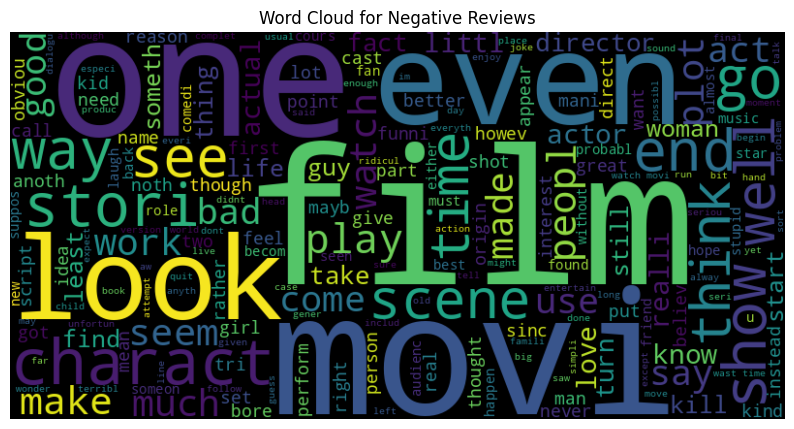

In [ ]:
from wordcloud import WordCloud

# Generate word clouds for positive and negative reviews
positive_reviews = " ".join(imdb_data[imdb_data['sentiment'] == 'positive']['cleaned_review'])
negative_reviews = " ".join(imdb_data[imdb_data['sentiment'] == 'negative']['cleaned_review'])

# Positive word cloud
plt.figure(figsize=(10, 6))
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Negative word cloud
plt.figure(figsize=(10, 6))
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

###**Final Sentiment Testing and Conclusion**

In [17]:
#Predict sentiment for new reviews
def predict_sentiment(new_reviews):
  new_reviews = [preprocess_text(review) for review in new_reviews]
  new_reviews_tfidf = tfidf_vectorizer.transform(new_reviews)
  predictions = svm.predict(new_reviews_tfidf)
  return predictions

#Request user input for reviews
print("Please enter a review to classify its sentiment (or 'exit' to quit):")
while True:
  user_input = input("Enter review: ")
  if user_input.lower() == 'exit':
    break

  predictions = predict_sentiment([user_input])
  sentiment = 'positive' if predictions[0] == 1 else 'negative'
  print(f"The sentiment of the review is: {sentiment}")

Please enter a review to classify its sentiment (or 'exit' to quit):
Enter review: The movie was bad
The sentiment of the review is: negative
Enter review: The movie was great
The sentiment of the review is: positive
Enter review: exit


The dataset was analyzed with no missing values, the dataset is balanced as per class distribution and some outliers were identified. All the steps of data processing was performed along with Lemmatization and stemming of words.
TF-IDF was used for feature extraction and sparse matrices for training and testing datasets were created.
Various classification models were experimented such as Logistic Regression,
Naive Bayes, Support Vector Machine (SVM), Random Forest, and Neural
Networks and after evaluating it with appropriate metrics, it was found that Logistic Regression model gave the highest accuracy of 88% while SVM and LSTM showed 87% accuracy but LSTM achieved 92% accuracy after 5 epochs.